## Objectives

At the end of the experiment, you will be able to

- understand how to visualize a time-series dataset (Australian Anti-diabetic drug sales time series dataset)
- understand how to find seasonality and trend and detect patterns in a time-series
- know why and how to deseasonalize and detrend a time series
- understand what is autocorrelation and partial autocorrelation function
- understand the significance of lag plots and how to plot them
- know why we smoothen a time-series and how we will do in a dataset
- understand the Granger Causality test to know if one time series helps forecast another



## Information

Exploratory Data Analysis (EDA) refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis, and to check assumptions with the help of summary statistics and graphical representations.

It is a good practice to understand the data first and try to gather as many insights from it. EDA is all about making sense of data in hand, before getting them dirty with it.


### Dataset Description

**Name:**

Monthly anti-diabetic drug sales in Australia from 1991 to 2008.

**Description:**

Total monthly scripts for pharmaceutical products falling under ATC code A10, as recorded by the Australian Health Insurance Commission. There are 204 entries, from 1991-07-01 to 2008-06-01 (Monthly sales values).

**Variables:**

Monthly time series of class ts.

### Setup Steps:

In [1]:
import wget

In [2]:
wget.download('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

100% [................................................................................] 4670 / 4670

'a10 (2).csv'

### Importing required packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from dateutil.parser import parse
from scipy import signal
from pandas.plotting import lag_plot
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
# Read dataset
df = pd.read_csv('a10.csv', parse_dates=['date'])
df.head()

date     value
0 1991-07-01  3.526591
1 1991-08-01  3.180891
2 1991-09-01  3.252221
3 1991-10-01  3.611003
4 1991-11-01  3.565869

In [3]:
# Read dataset with 'date' as index
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
df.head()

value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869

### Visualizing a time series

Let’s visualise the series using matplotlib.

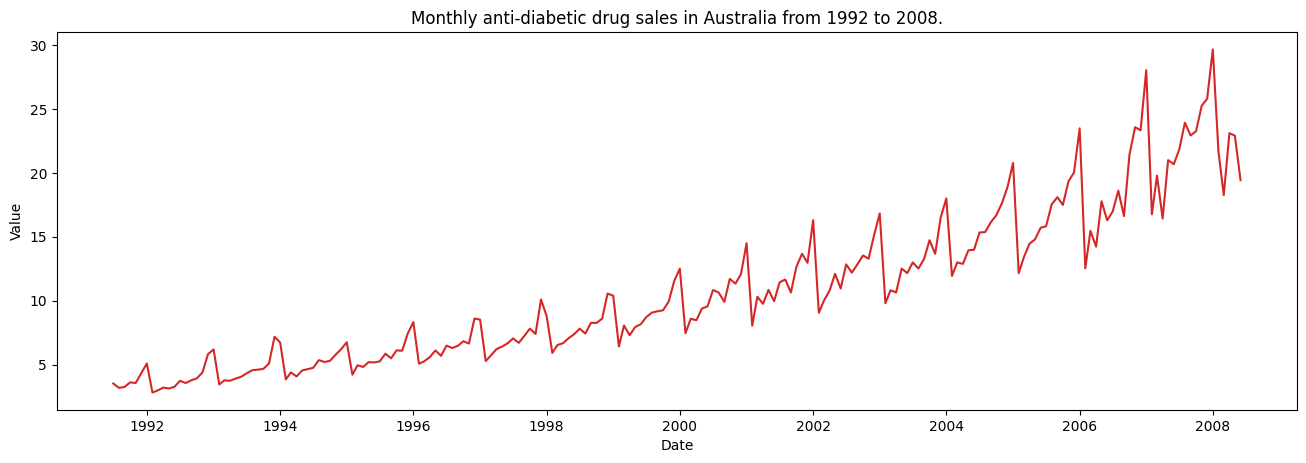

In [4]:
# Define function to plot the time series
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')

There is a clear and increasing trend. There is also a strong seasonal pattern that increases in size as the level of the series increases. The sudden drop at the start of each year is caused by a government subsidization scheme that makes it cost-effective for patients to stockpile drugs at the end of the calendar year. Any forecasts of this series would need to capture the seasonal pattern and the fact that the trend is changing slowly.

### Seasonal Plot of a Time Series

In [5]:
# Reset the index
df.reset_index(inplace=True)

In [6]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prepare Colors
np.random.seed(100)


mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

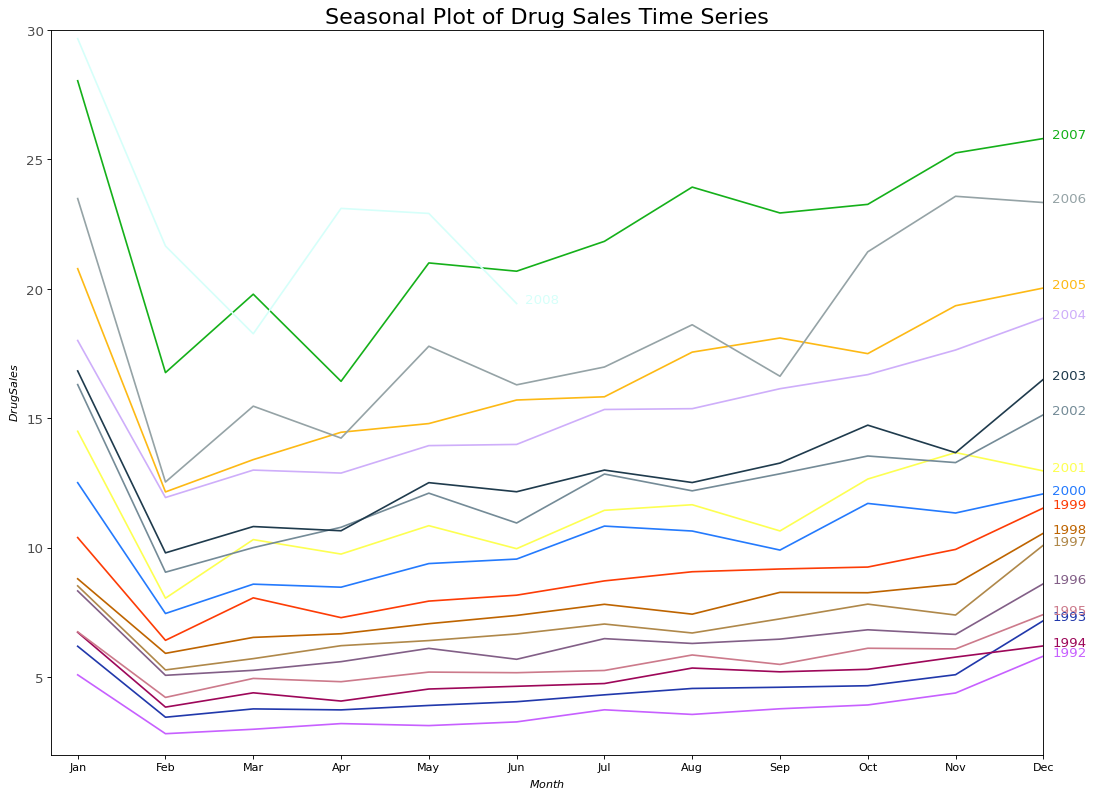

In [7]:
# Visualize seasonal variaton in drug sales
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

There is a large jump in sales in January each year. The graph also shows that there was an unusually small number of sales in March 2008 (most other years show an increase between February and March). The small number of sales in June 2008 is probably due to incomplete counting of sales at the time the data were collected.

However, as years progress, the drug sales increase overall. We can nicely visualize this trend and how it varies each year in a nice year-wise boxplot. Likewise, we can do a month-wise boxplot to visualize the monthly distributions.

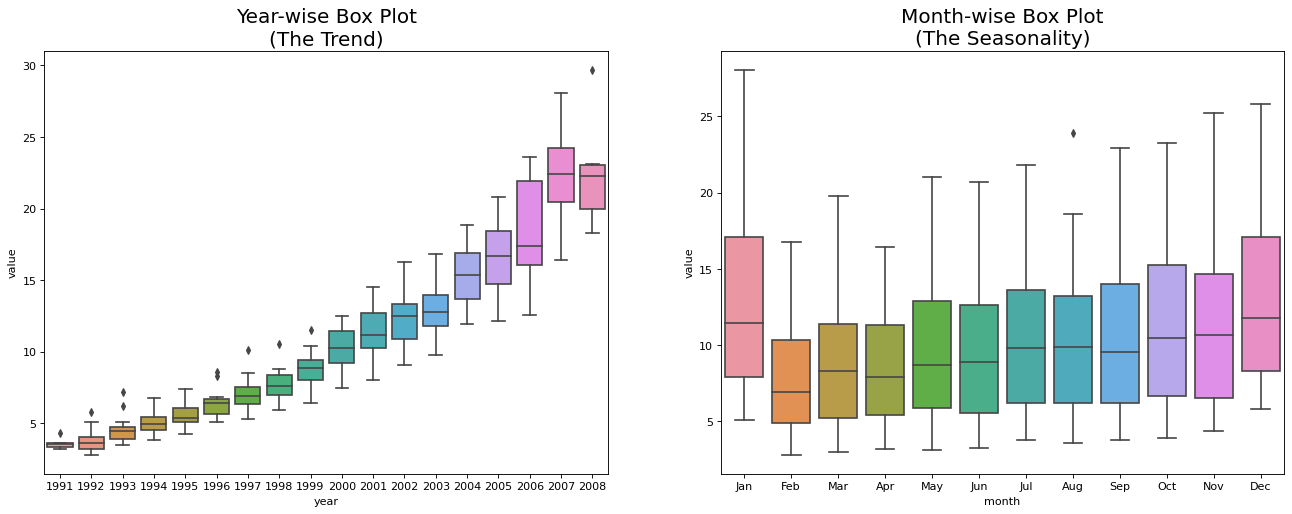

In [8]:
# Visualize the yearly and monthly drug sales using box plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

The boxplots make the year-wise and month-wise distributions evident. Also, in a month-wise boxplot, the months of December and January clearly have higher drug sales, which can be attributed to the holiday discounts season.

So far, we have seen the similarities to identify the pattern. Now, how to find out any deviations from the usual pattern?

###  Patterns in a time series

Any time series may be split into the following components: Base Level + Trend + Seasonality + Error

**Trend:**

A trend exists when there is a long-term increase or decrease in the data.
It does not have to be linear. Sometimes we will refer to a trend as “changing direction” when it might go from an increasing trend to a decreasing trend.
There is a trend in the antidiabetic drug sales data.

**Seasonality:**

A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week.
Seasonality is always of a fixed and known frequency.
The monthly sales of antidiabetic drugs above show seasonality which is induced partly by the change in the cost of the drugs at the end of the calendar year.

**Residuals:**

When you remove the trend, seasonality, and other observable patterns from the data, white noise is left and this is termed as residuals.

A time series may be imagined as a combination of the trend, seasonality and the error/residual terms.

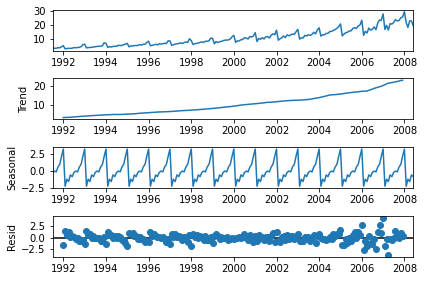

In [9]:
# Setting index back to date
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')

# Applying seasonal decompose
result = seasonal_decompose(df, model='additive')

# Plotting trend, seasonality and both trend and seasonality in drug sales data
result.plot()
plt.show()

Another aspect to consider is the cyclic behavior. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. Care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect.

So, How to differentiate between a ‘cyclic’ vs ‘seasonal’ pattern?

If the patterns are not of fixed calendar-based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.

### Additive and Multiplicative Time-Series

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

$\text{Additive time series:}$

$\hspace{0.5cm}\text{=> Value = Base Level + Trend + Seasonality + Error}$

$\text{Multiplicative Time Series:}$

$\hspace{0.5cm}\text{=> Value = Base Level x Trend x Seasonality x Error}$


###  Detrend a time series

Detrending a time series is to remove the trend component from a time series. But how to extract the trend? There are multiple approaches.

1. Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms $(x^2)$ in the model.

2. Subtract the trend component obtained from time series decomposition we saw earlier.

3. Subtract the mean

4. Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

Let’s implement the first two methods.

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the least squares fit')

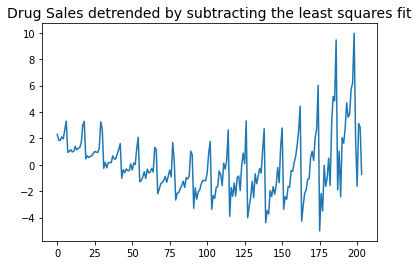

In [10]:
# Using scipy: Subtract the line of best fit
detrended = signal.detrend(df.value.values)
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=14)

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

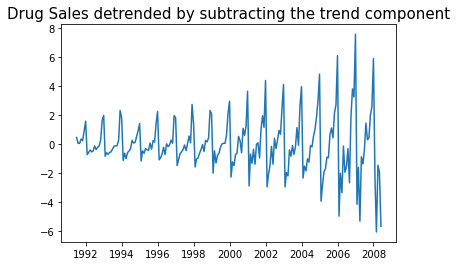

In [11]:
# Decomposing time-series first
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
# Detrending the time-series by trend component
detrended = df.value.values - result_mul.trend

# Plotting the detrended time series
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=15)

### Deseasonalize a time series

There are multiple approaches to deseasonalize a time series as well. Below are a few:

1. Take a moving average with length as the seasonal window. This will smoothen the series in the process.

2. Seasonal difference the series (subtract the value of previous season from the current value)

3. Divide the series by the seasonal index obtained from STL decomposition

If dividing by the seasonal index does not work well, try taking a log of the series and then do the deseasonalizing. You can later restore to the original scale by taking an exponential.

In [12]:
# Time Series Decomposition
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize the time series
deseasonalized = df.value.values / result_mul.seasonal

[]

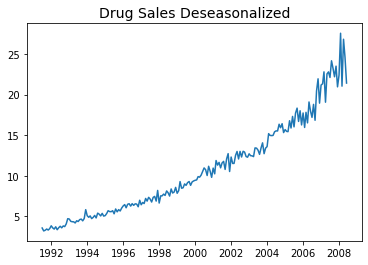

In [13]:
# Visualize deseasonalize tiem series
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=14)
plt.plot()

### Autocorrelation and Partial Autocorrelation Functions

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

Running the below code, two 2D plots showing the lag value along the x-axis and the correlation (for both acf and pacf) on the y-axis between -1 and 1.

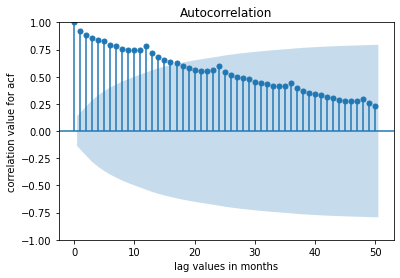

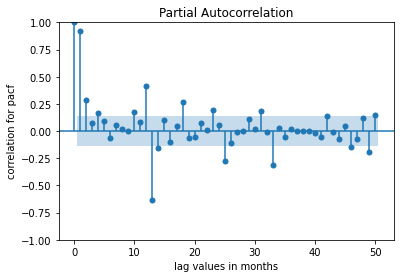

In [14]:
# Draw ACF Plot
acf_50 = plot_acf(df['value'], lags=50)
plt.xlabel('lag values in months')
plt.ylabel('correlation value for acf')
acf_50.show()

# Draw PACF Plot
pacf_50 = plot_pacf(df['value'], lags=50)
plt.xlabel('lag values in months')
plt.ylabel('correlation for pacf')
pacf_50.show()

Confidence intervals are drawn as a `blue part`. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this cone are very likely a correlation.

**Intuition of ACF plot**

As per the above ACF plot, we have a good correlation up to 14 to 15 lag, this is the lag after which the plot cuts the upper confidence interval.

**Intuition of PACF plot**

If we see the PACF plot there are many instances where correlation is the above upper confidence band as PACF calculates correlations of lags of time series with residuals and our series itself is a linear combination of residual and its lagged values. Hence we can get a good correlation for near as well as past lags.






### Lag Plots

A Lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series like the one you see below, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

In the below example on Sunspots area time series, the plots get more and more scattered as the n_lag increases.

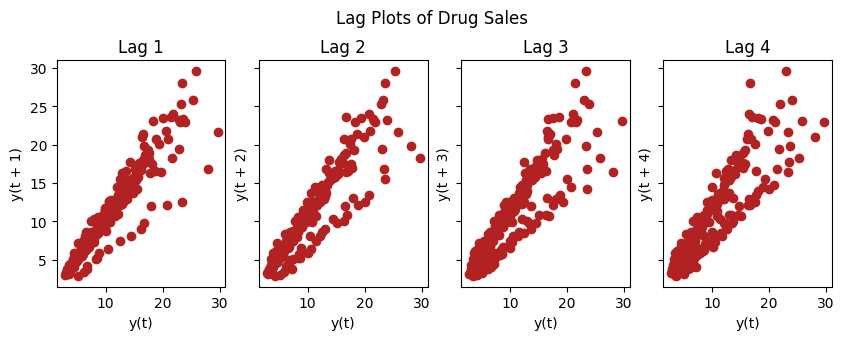

In [15]:
# Visualize lag plots
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

### How to smoothen a time series

So how to smoothen a series? Let’s discuss the following methods:

1. Take a moving average
2. Do a LOESS smoothing (Localized Regression)
3. Do a LOWESS smoothing (Locally Weighted Regression)

Moving average is nothing but the average of a rolling window of defined width. But we must choose the window-width wisely, because, large window-size will over-smooth the series. For example, a window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect.

LOESS, short for ‘Localized regression’ fits multiple regressions in the local neighborhood of each point. It is implemented in the statsmodels package, where you can control the degree of smoothing using frac argument which specifies the percentage of data points nearby that should be considered to fit a regression model.

Text(0.5, 0.95, 'How to Smoothen a Time Series')

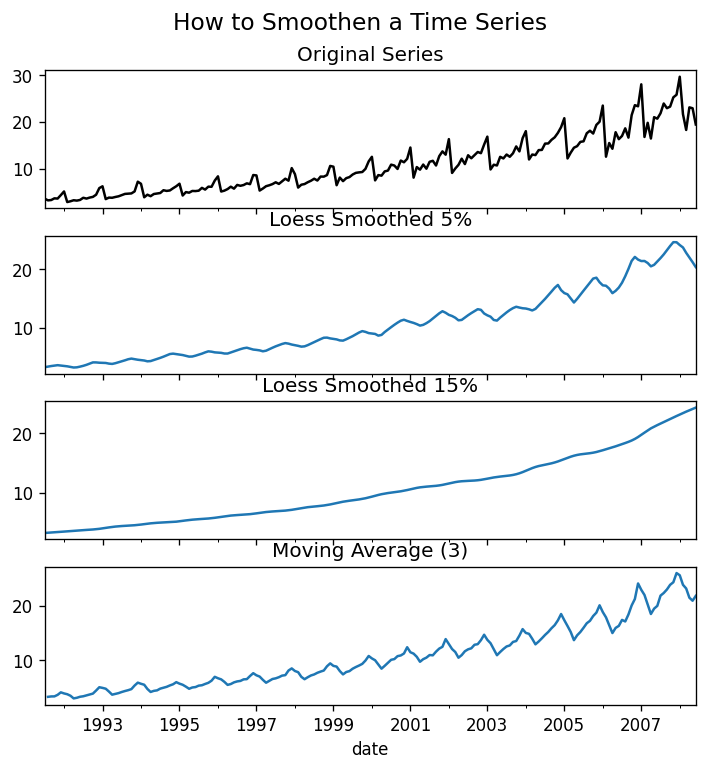

In [16]:
# 1. Moving Average
df_ma = df.value.rolling(3, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.05)[:, 1], index=df.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.15)[:, 1], index=df.index, columns=['value'])

# Visualize Moving average and Loess smoothing
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df['value'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)

### Granger Causality test to know if One Time Series helps Forecast Another

Granger causality test is used to determine if one time series will be useful to forecast another.

**How the does Granger causality test work?**

It is based on the idea that if X causes Y, then the forecast of Y based on previous values of Y and the previous values of X should outperform the forecast of Y based on previous values of Y alone.

So, understand that Granger causality should not be used to test if a lag of Y causes Y. Instead, it is generally used on exogenous (not Y lag) variables only.

It is nicely implemented in the statsmodel package.

It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor (X) is in the second column.

The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. If the P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said lag of X is indeed useful.

The second argument maxlag says till how many lags of Y should be included in the test.

In [17]:
# Perform Granger Causality test
df.reset_index(inplace=True)
df['month'] = df.date.dt.month
grangercausalitytests(df[['value', 'month']], maxlag=2);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=54.7797 , p=0.0000  , df_denom=200, df_num=1
ssr based chi2 test:   chi2=55.6014 , p=0.0000  , df=1
likelihood ratio test: chi2=49.1426 , p=0.0000  , df=1
parameter F test:         F=54.7797 , p=0.0000  , df_denom=200, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=162.6989, p=0.0000  , df_denom=197, df_num=2
ssr based chi2 test:   chi2=333.6567, p=0.0000  , df=2
likelihood ratio test: chi2=196.9956, p=0.0000  , df=2
parameter F test:         F=162.6989, p=0.0000  , df_denom=197, df_num=2


In the above case, the P-Values are Zero for all tests. So the ‘month’ indeed can be used to forecast the Drug Sales.

We started from the very basics and understood the various characteristics of a time series. Once the analysis is done the next step is to begin forecasting.

# Lets try different libraries to explore EDA capabilities

## Some of the sample libraries would be - Darts, Auto_TS (Nixtla) , Statsforecast, Scalecast, GluonTS, PDMArima

### Refer to requirements.txt for library details


In [18]:
!pip3 install -r requirements.txt

In [21]:
!pip3 install --upgrade scalecast

In [19]:
import darts as dt
import pmdarima as pdm
import autotimeseries as ats  # << This is different from Auto_TS >>
import statsforecast as stf
import skforecast as skf
import scalecast as scl

In [20]:
df.head()

date     value  month
0 1991-07-01  3.526591      7
1 1991-08-01  3.180891      8
2 1991-09-01  3.252221      9
3 1991-10-01  3.611003     10
4 1991-11-01  3.565869     11

# Using Darts

Darts is a Python library for user-friendly forecasting and anomaly detection on time series. It contains a variety of models, from classics such as ARIMA to deep neural networks. The forecasting models can all be used in the same way, using fit() and predict() functions, similar to scikit-learn. The library also makes it easy to backtest models, combine the predictions of several models, and take external data into account. Darts supports both univariate and multivariate time series and models. The ML-based models can be trained on potentially large datasets containing multiple time series, and some of the models offer a rich support for probabilistic forecasting.

Darts also offers extensive anomaly detection capabilities. For instance, it is trivial to apply PyOD models on time series to obtain anomaly scores, or to wrap any of Darts forecasting or filtering models to obtain fully fledged anomaly detection models.

- https://github.com/unit8co/darts
- https://unit8co.github.io/darts/quickstart/00-quickstart.html
- https://unit8co.github.io/darts/generated_api/darts.utils.statistics.html?highlight=decompo  >> Stats Module of Darts

In [21]:
from darts import TimeSeries
from darts.utils import statistics as st

df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
series = TimeSeries.from_dataframe(df)

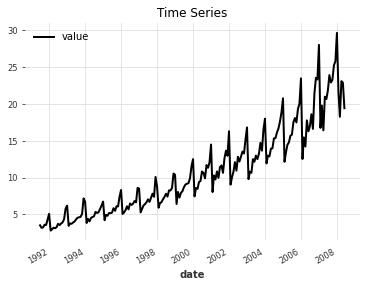

In [22]:
series.plot()
plt.title('Time Series')
plt.show()

In [23]:
# decomposition = series.decompose()
# decomposition.plot()
# plt.show()

seasonality = st.check_seasonality(series)
print('Seasonality: ', seasonality)

Seasonality:  (True, 10)


In [24]:
trend,season = st.extract_trend_and_seasonality(series)

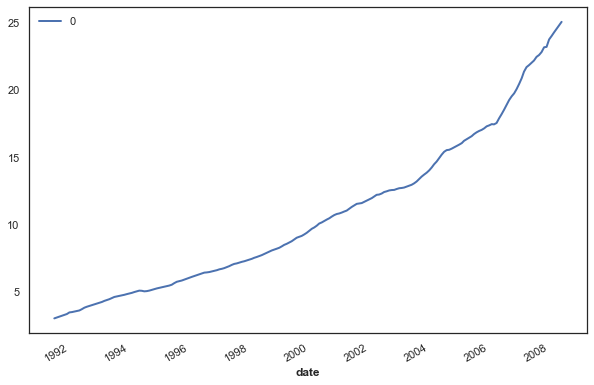

In [108]:
trend.plot()

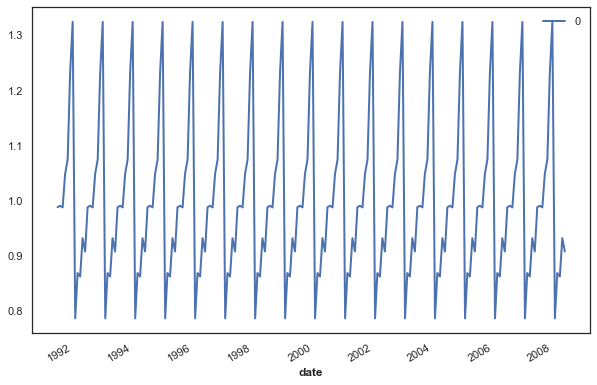

In [109]:
season.plot()

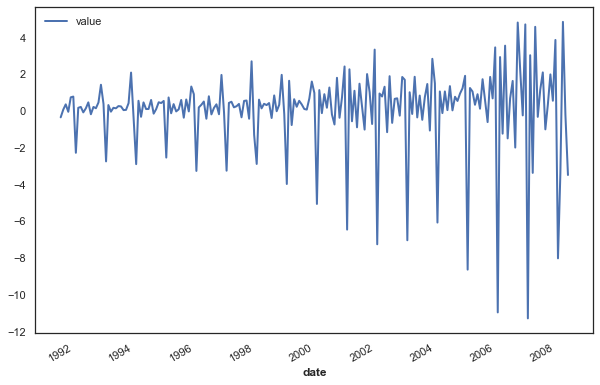

In [110]:
series.diff().plot()

In [113]:
series

<TimeSeries (DataArray) (date: 204, component: 1, sample: 1)>
array([[[ 3.526591  ]],

       [[ 3.180891  ]],

       [[ 3.252221  ]],

       [[ 3.611003  ]],

       [[ 3.565869  ]],

       [[ 4.306371  ]],

       [[ 5.088335  ]],

       [[ 2.81452   ]],

       [[ 2.985811  ]],

       [[ 3.20478   ]],

...

       [[22.93035694]],

       [[23.26333992]],

       [[25.25003022]],

       [[25.80609   ]],

       [[29.665356  ]],

       [[21.654285  ]],

       [[18.264945  ]],

       [[23.107677  ]],

       [[22.91251   ]],

       [[19.43174   ]]])
Coordinates:
  * date       (date) datetime64[ns] 1991-07-01 1991-08-01 ... 2008-06-01
  * component  (component) object 'value'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

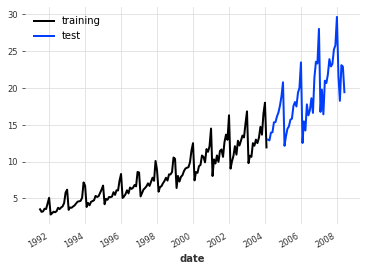

In [25]:
train, test = series.split_before(0.75)
train.plot(label="training")
test.plot(label="test")

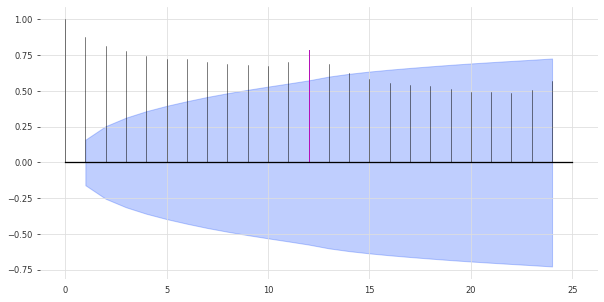

In [26]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

In [27]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


### darts.utils.statistics package contains all the essential functions for performing EDA
### It is basically built on top of statsmodels.tsa

In [28]:
result = st.granger_causality_tests(series, series, 2)

C:\Users\prateek.kumar\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
C:\Users\prateek.kumar\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=201, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=1264.3549, p=0.0000  , df_denom=201, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=199, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=716.2668, p=0.0000  , df_denom=199, df_num=2


# Using PDMArima - enhancements Based on ARIMA and its variations

Pmdarima (originally pyramid-arima, for the anagram of 'py' + 'arima') is a statistical library designed to fill the void in Python's time series analysis capabilities. This includes:

The equivalent of R's auto.arima functionality
A collection of statistical tests of stationarity and seasonality
Time series utilities, such as differencing and inverse differencing
Numerous endogenous and exogenous transformers and featurizers, including Box-Cox and Fourier transformations
Seasonal time series decompositions
Cross-validation utilities
A rich collection of built-in time series datasets for prototyping and examples
Scikit-learn-esque pipelines to consolidate your estimators and promote productionization

Pmdarima wraps statsmodels under the hood, but is designed with an interface that's familiar to users coming from a scikit-learn background.

- https://alkaline-ml.com/pmdarima/user_guide.html
- https://alkaline-ml.com/pmdarima/usecases/sun-spots.html#examining-the-data

In [29]:
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
df.head()

value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869

In [30]:
df.value.dtype

dtype('float64')

In [31]:
train, test = df[:140], df[140:]

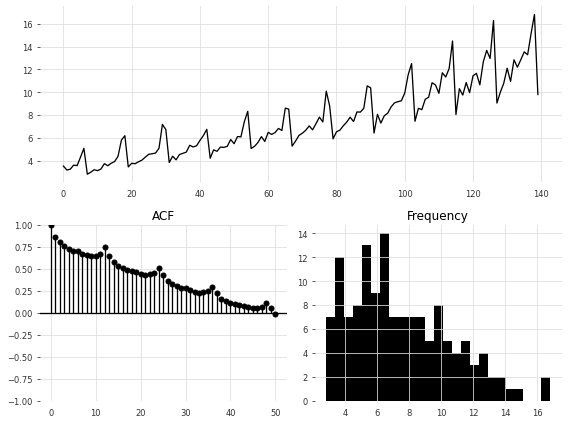

In [32]:
from pmdarima.utils import tsdisplay

tsdisplay(train, lag_max=50)

Reading this plot can give us several pieces of information:

- We are looking at a seasonal time series. Our apriori knowledge of the dataset informs us that this data has a seasonal periodicity of m=12.
- There seems to be some data skew, looking at the histogram. It is very zero-inflated. A lot of the statistical techniques used in time series modeling behave better when the data is normally distributed, so this may be something to look into.

In [33]:
m1 = pdm.auto_arima(train, error_action='ignore', seasonal=True, m=1)
m12 = pdm.auto_arima(train, error_action='ignore', seasonal=True, m=12)

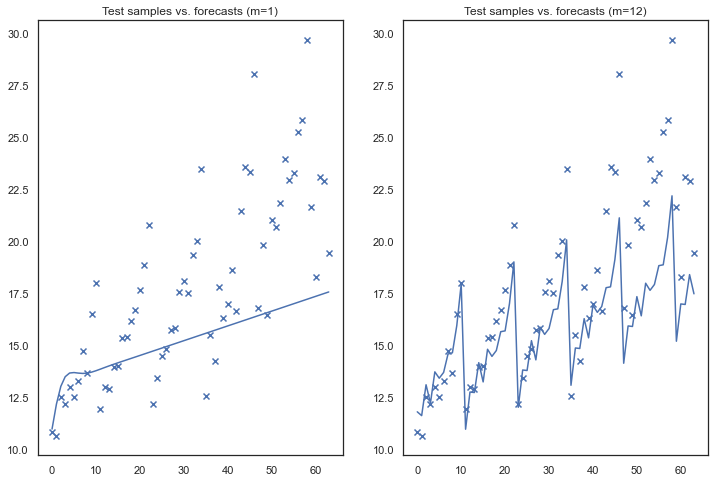

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
x = np.arange(test.shape[0])

axes[0].scatter(x, test, marker='x')
axes[0].plot(x, m1.predict(n_periods=test.shape[0]))
axes[0].set_title('Test samples vs. forecasts (m=1)')

axes[1].scatter(x, test, marker='x')
axes[1].plot(x, m12.predict(n_periods=test.shape[0]))
axes[1].set_title('Test samples vs. forecasts (m=12)')

plt.show()

In [36]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [37]:
auto = pdm.auto_arima(train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=464.350, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=524.292, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=508.666, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=476.616, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=522.406, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=473.798, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=473.724, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=471.955, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=467.856, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=475.127, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 

In [38]:
auto.order

(2, 1, 2)

In [37]:
test.value.dtype

dtype('float64')

In [39]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test.value:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test, forecasts)}")
print(f"SMAPE: {smape(test, forecasts)}")

Mean squared error: 8.218729272706799
SMAPE: 11.909652366523575


In [40]:
fc, conf = forecast_one_step()

In [41]:
fc

23.214259565908257

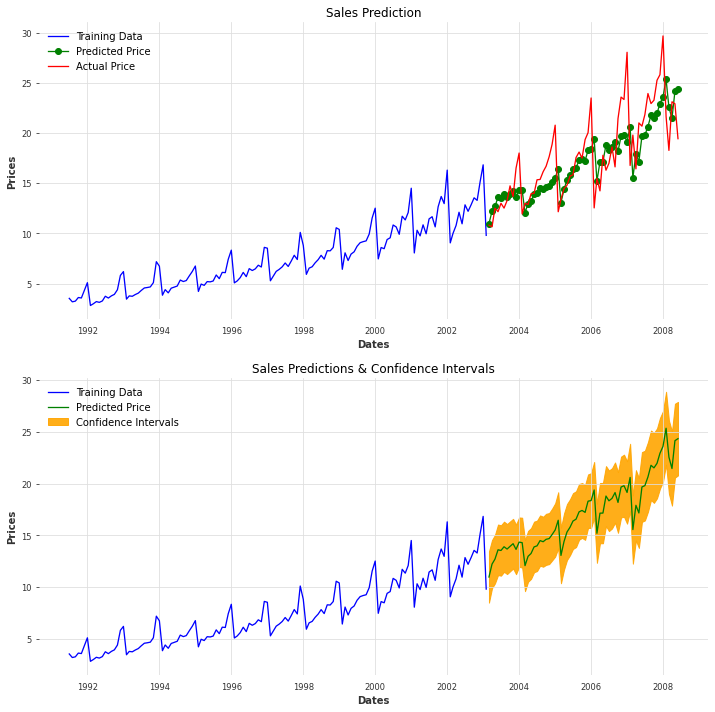

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train, color='blue', label='Training Data')
axes[0].plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test.index, test, color='red', label='Actual Price')
axes[0].set_title('Sales Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

#axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train, color='blue', label='Training Data')
axes[1].plot(test.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Sales Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

# Using Auto_TS >> Hard dependency of fbProphet

Not suitable for EDA anyways. Good for auto_modelling

- https://github.com/AutoViML/Auto_TS/blob/master/example_notebooks/autots_multivariate_example.ipynb
- https://github.com/AutoViML/Auto_TS/tree/master/example_notebooks

In [42]:
from auto_ts import auto_timeseries  # > For fbprophet we need to downgrade python version below 3.6

ModuleNotFoundError: No module named 'fbprophet'

In [45]:
%pip list

Package                       Version
----------------------------- --------------------
adagio                        0.2.4
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
alembic                       1.10.1
altair                        4.2.0
anaconda-client               1.9.0
anaconda-navigator            2.2.0
anaconda-project              0.10.2
analytics-python              1.4.0
ansi2html                     1.8.0
antlr4-python3-runtime        4.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astor                         0.8.1
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
auto-ts                       0.0.68
Aut


dash-core-components          2.0.0
dash-html-components          2.0.0
dash-table                    5.0.0
dask                          2022.2.1
datashader                    0.13.0
datashape                     0.5.4
debugpy                       1.5.1
decorator                     5.1.1
defusedxml                    0.7.1
diff-match-patch              20200713
distributed                   2022.2.1
docutils                      0.17.1
eli5                          0.13.0
entrypoints                   0.4
enum-compat                   0.0.3
ephem                         4.1.4
et-xmlfile                    1.1.0
executing                     0.8.3
fastapi                       0.78.0
fastjsonschema                2.15.1
ffmpy                         0.3.0
filelock                      3.6.0
flake8                        3.9.2
Flask                         1.1.2
Flask-Cors                    3.0.10
fonttools                     4.25.0
frozenlist                    1.2.0
fs           

ruamel-yaml-conda             0.15.100
s3fs                          0.4.2
s3transfer                    0.5.0
SCALECAST                     0.17.12
scikit-image                  0.19.2
scikit-learn                  1.0.2
scikit-learn-intelex          2021.20220215.102710
scikit-optimize               0.9.0
scipy                         1.7.3
Scrapy                        2.6.1
seaborn                       0.11.2
semver                        2.13.0
Send2Trash                    1.8.0
service-identity              18.1.0
setuptools                    61.2.0
setuptools-git                1.2
setuptools-scm                7.1.0
shap                          0.41.0
sip                           4.19.13
six                           1.16.0
skforecast                    0.6.0
slicer                        0.0.7
smart-open                    5.1.0
smmap                         5.0.0
sniffio                       1.2.0
snowballstemmer               2.2.0
sortedcollections             2.1.0
s

# Using Nixtla (Autotimeseries) >> Need to explore more

- This library has individual packages for specific tasks like tspreprocess, tsfeatures, tsforecast et cetra. 
- Needs AWS bucket details for further processing

In [43]:
from autotimeseries.core import AutoTS

In [44]:
autotimeseries = AutoTS(df)

TypeError: __init__() missing 4 required positional arguments: 'api_id', 'api_key', 'aws_access_key_id', and 'aws_secret_access_key'

# Using Scalecast

Scalecast helps you forecast time series. Here is how to initiate its main object:

from scalecast.Forecaster import Forecaster

> f = Forecaster(
    y = array_of_values,
    current_dates = array_of_dates,
    future_dates=fcst_horizon_length,
    test_length = 0, # do you want to test all models? if so, on how many or what percent of observations?
    cis = False, # evaluate conformal confidence intervals for all models?
    metrics = ['rmse','mape','mae','r2'], # what metrics to evaluate over the validation/test sets?
)

Uniform ML modeling (with models from a diverse set of libraries, including scikit-learn, statsmodels, and tensorflow), reporting, and data visualizations are offered through the Forecaster and MVForecaster interfaces. Data storage and processing then becomes easy as all applicable data, predictions, and many derived metrics are contained in a few objects with much customization available through different modules. Feature requests and issue reporting are welcome!

- https://github.com/mikekeith52/scalecast
- https://scalecast-examples.readthedocs.io/en/latest/misc/introduction/Introduction2.html


In [45]:
df.reset_index(inplace=True)
volume = df.groupby('date')['value'].sum()

In [46]:
volume

date
1991-07-01     3.526591
1991-08-01     3.180891
1991-09-01     3.252221
1991-10-01     3.611003
1991-11-01     3.565869
                ...    
2008-02-01    21.654285
2008-03-01    18.264945
2008-04-01    23.107677
2008-05-01    22.912510
2008-06-01    19.431740
Name: value, Length: 204, dtype: float64

In [48]:
from scalecast.Forecaster import Forecaster

f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = 13,
)

f

Forecaster(
    DateStartActuals=1991-07-01T00:00:00.000000000
    DateEndActuals=2008-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=204
    ForecastLength=13
    Xvars=[]
    Differenced=0
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

## EDA

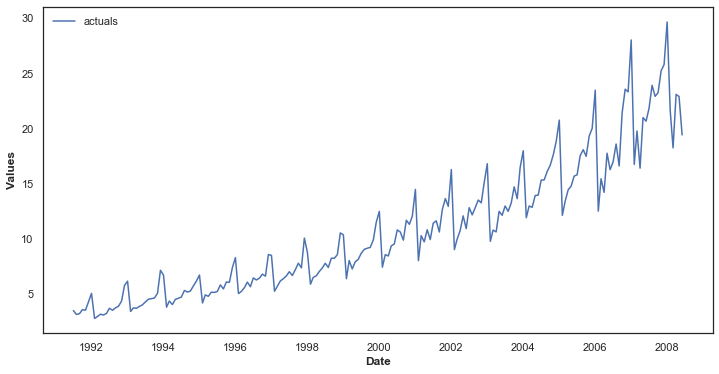

In [49]:
f.plot()
plt.show()

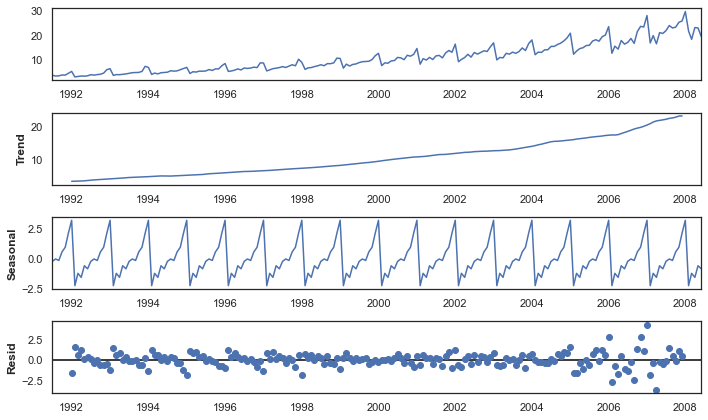

In [50]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

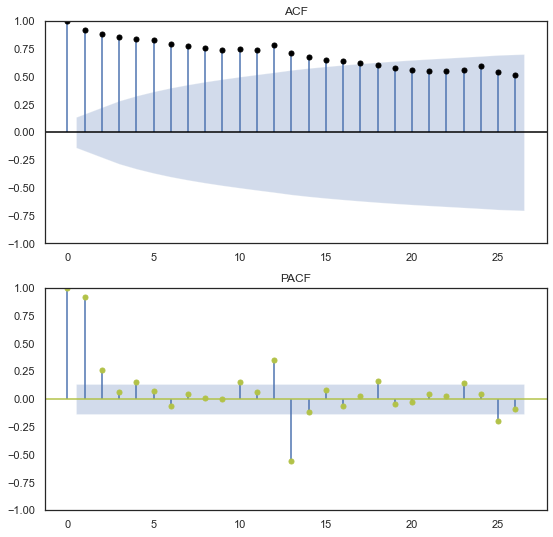

In [51]:
figs, axs = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=axs[0],title='ACF',lags=26,color='black')
f.plot_pacf(ax=axs[1],title='PACF',lags=26,color='#B2C248',method='ywm')
plt.show()

In [66]:
f.set_test_length(.15)

In [67]:
# default args below
f.eval_cis(
    mode = True, # tell the object to evaluate intervals
    cilevel = .95, # 95% confidence level
)

In [68]:
f.add_time_trend()
f.add_seasonal_regressors('month',raw=False,sincos=True)

In [69]:
f.add_ar_terms(13)

In [70]:
f

Forecaster(
    DateStartActuals=1991-07-01T00:00:00.000000000
    DateEndActuals=2008-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=204
    ForecastLength=13
    Xvars=['t', 'monthsin', 'monthcos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13']
    Differenced=0
    TestLength=30
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [71]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=13)

In [72]:
f.set_estimator('lasso')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

In [73]:
f.set_estimator('ridge')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

In [74]:
f.set_estimator('elasticnet')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

In [75]:
f.set_estimator('sgd')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

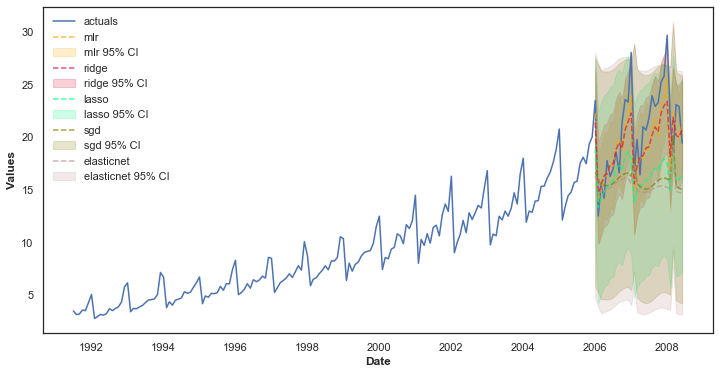

In [76]:
f.plot_test_set(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='LevelTestSetMAPE')
plt.show()

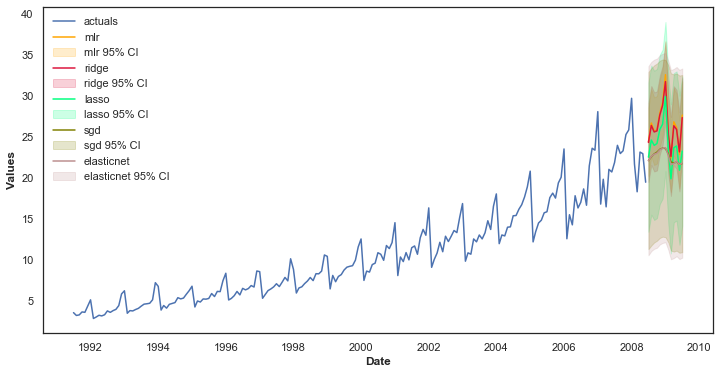

In [77]:
f.plot(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='TestSetRMSE')
plt.show()

In [79]:
f.set_estimator('prophet')
f.manual_forecast()

14:46:40 - cmdstanpy - INFO - Chain [1] start processing
14:46:40 - cmdstanpy - INFO - Chain [1] done processing
14:46:41 - cmdstanpy - INFO - Chain [1] start processing
14:46:41 - cmdstanpy - INFO - Chain [1] done processing


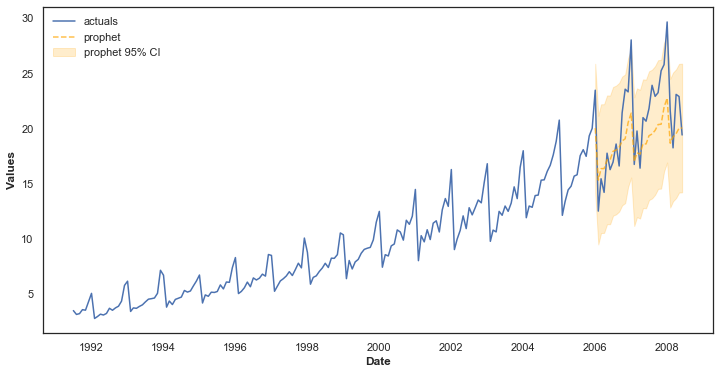

In [80]:
f.plot_test_set(models='prophet',ci=True)
plt.show()

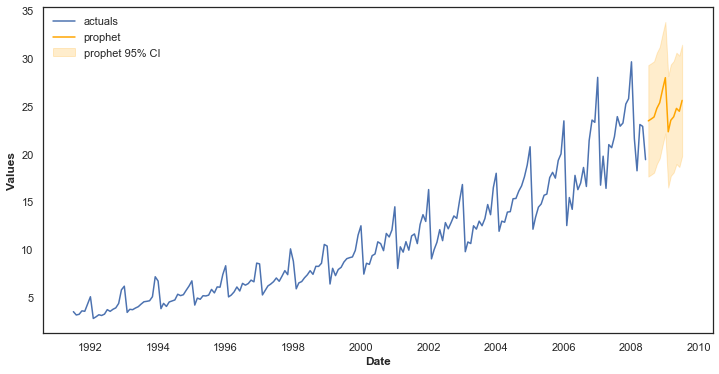

In [81]:
f.plot(models='prophet',ci=True)
plt.show()

 Likewise we can also create non-linear mdels and check the accuracy. 
 Stacking of different models is also possible with Scalecast with in-built functions
 > Reference Notebook 
 - https://scalecast-examples.readthedocs.io/en/latest/misc/introduction/Introduction2.html
 
Overall this library is amazing with very detailed descriptions along with all the essential and advanced built-in implementations.

# Using Skforecast  
- https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/input-data.html
- https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
- https://joaquinamatrodrigo.github.io/skforecast/0.6.0/examples/examples.html

## Features
- Create recursive autoregressive forecasters from any regressor that follows the scikit-learn API.
- Create direct autoregressive forecasters from any regressor that follows the scikit-learn API.
- Create multi-series autoregressive forecasters from any regressor that follows the scikit-learn API.
- Include exogenous variables as predictors.
- Include custom predictors (rolling mean, rolling variance ...).
- Multiple backtesting methods for model validation.
- Grid search, random search and bayesian search to find optimal lags (predictors) and best hyperparameters.
- Include custom metrics for model validation and grid search.
- Prediction interval estimated by bootstrapping and quantile regression.
- Get predictor importance.
- Forecaster in production.

### Skforecast is a python library that eases using scikit-learn regressors as multi-step forecasters. It also works with any regressor compatible with the scikit-learn API (pipelines, CatBoost, LightGBM, XGBoost, Ranger...)

This library is a wrapper class on top of Scikit-learn package. There are no specific EDA capabilities of its own rather 
there are other very nice features as part of this library like different types of forecasting(single, multi), hyperparam tuning, Backtesting.

# Using Statsforecast

StatsForecast offers a collection of widely used univariate time series forecasting models, including automatic ARIMA, ETS, CES, and Theta modeling optimized for high performance using numba. It also includes a large battery of benchmarking models

- https://github.com/Nixtla/statsforecast
- https://nixtla.github.io/statsforecast/examples/getting_started_complete.html

## Features
- Fastest and most accurate implementations of AutoARIMA, AutoETS, AutoCES, MSTL and Theta in Python.
- Out-of-the-box compatibility with Spark, Dask, and Ray.
- Probabilistic Forecasting and Confidence Intervals.
- Support for exogenous Variables and static covariates.
- Anomaly Detection.
- Familiar sklearn syntax: .fit and .predict.

### Also includes Garch and Arch models for measuring non-constant volatility

### EDA

In [52]:
from statsforecast import StatsForecast

In [53]:
df = pd.read_csv('a10.csv', parse_dates=['date'])
df.head()

date     value
0 1991-07-01  3.526591
1 1991-08-01  3.180891
2 1991-09-01  3.252221
3 1991-10-01  3.611003
4 1991-11-01  3.565869

In [54]:
#df.reset_index(inplace=True)
df['unique_id'] = 'TS1'
df.rename(columns={'date':'ds','value':'y'},inplace=True)

In [55]:
StatsForecast.plot(df)

In [56]:
df

ds          y unique_id
0   1991-07-01   3.526591       TS1
1   1991-08-01   3.180891       TS1
2   1991-09-01   3.252221       TS1
3   1991-10-01   3.611003       TS1
4   1991-11-01   3.565869       TS1
..         ...        ...       ...
199 2008-02-01  21.654285       TS1
200 2008-03-01  18.264945       TS1
201 2008-04-01  23.107677       TS1
202 2008-05-01  22.912510       TS1
203 2008-06-01  19.431740       TS1

[204 rows x 3 columns]

In [57]:
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

In [58]:
# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length=12),
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=12),
    HistoricAverage(),
    DOT(season_length=24)
]

In [59]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=df, 
    models=models,
    freq='M', 
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=12)
)

In [60]:
forecasts_df = sf.forecast(h=48, level=[90])  ## h is horizon, level indicates Conf Intrvl

forecasts_df.head()

ds  AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90  \
unique_id                                                           
TS1       2008-06-30  23.782778        22.240366        25.325191   
TS1       2008-07-31  24.619720        23.071388        26.168055   
TS1       2008-08-31  23.952768        22.333874        25.571663   
TS1       2008-09-30  25.310507        23.644875        26.976137   
TS1       2008-10-31  27.120533        25.404892        28.836174   

           HoltWinters  HoltWinters-lo-90  HoltWinters-hi-90  CrostonClassic  \
unique_id                                                                      
TS1          21.834890          16.144831          27.524950       21.812592   
TS1          23.930204          18.240145          29.620264       21.812592   
TS1          22.930357          17.240297          28.620417       21.812592   
TS1          23.263340          17.573280          28.953400       21.812592   
TS1          25.250031          19.559971          30.940090       21.812592   

           SeasonalNaive  SeasonalNaive-lo-90  SeasonalNaive-hi-90  \
unique_id                                                            
TS1            21.834890            16.144831            27.524950   
TS1            23.930204            18.240145            29.620264   
TS1            22.930357            17.240297            28.620417   
TS1            23.263340            17.573280            28.953400   
TS1            25.250031            19.559971            30.940090   

           HistoricAverage  HistoricAverage-lo-90  HistoricAverage-hi-90  \
unique_id                                                                  
TS1              10.694427                0.87205              20.516802   
TS1              10.694427                0.87205              20.516802   
TS1              10.694427                0.87205              20.516802   
TS1              10.694427                0.87205              20.516802   
TS1              10.694427                0.87205              20.516802   

           DynamicOptimizedTheta  DynamicOptimizedTheta-lo-90  \
unique_id                                                       
TS1                    23.454502                    22.198387   
TS1                    23.335070                    21.868053   
TS1                    23.440357                    21.656307   
TS1                    25.125320                    23.477955   
TS1                    25.942152                    24.382549   

           DynamicOptimizedTheta-hi-90  
unique_id                               
TS1                          25.038860  
TS1                          24.472668  
TS1                          24.826109  
TS1                          26.506231  
TS1                          27.727428

In [61]:
sf.plot(df,forecasts_df)

# EDA class containing all the above functions

write a python class for EDA on timeseries including all critical functions, statistical tests, 
filters like bkfilter,hpfilter, granger casuality test, acf,pacf, seasonal decompose, lag plots, 
transformations like boxcox, log, percentage change, different plotting functions, loess, 
lowess smoothing, moving averages. Include some functions from scalecast library as well

continue with these functions as well - calculate_autocorrelation , calculate_partial_autocorrelation, plot_autocorrelation, plot_density, plot_boxplot, plot_histogram, calculate_adf_test, calculate_kpss_test, , plot_loess_smoothing, apply_baxter_king_filter, apply_hodrick_prescott_filter

In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.filters.bk_filter import bkfilter
from statsmodels.tsa.filters.hp_filter import hpfilter
import scalecast as sc
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scalecast.Forecaster import Forecaster
from scipy.stats import boxcox
from scipy.stats import normaltest
from hurst import compute_Hc, random_walk
from scipy import signal
from pmdarima.arima import ndiffs
#from scalecast.MVForecaster import MVForecaster

#from scalecast.detrender import linear_detrend
#from scalecast.seasonal import seasonal_decompose
#from darts.models import AutoARIMA


class EDA:
    def __init__(self, data):
        self.data = data
        
        
    def print_summary(self):
        print("Data Summary:")
        print(self.data.head())
        print('\n')
        print(f"Number of observations: {len(self.data)}")
        print(f"Data type: {self.data.dtypes[0]}")
        print(f"Start date: {self.data.index[0]}")
        print(f"End date: {self.data.index[-1]}")
        print(f"Missing values: {self.data.isnull().sum().sum()}")
        
        
    def plot_time_series(self, title='Time Series Plot', xlabel='Time', ylabel='Value'):
        plt.figure(figsize=(10, 6))
        plt.plot(self.data)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    
    def plot_acf_pacf(self, lags=30):
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
        plot_acf(self.data, ax=ax[0], lags=lags)
        plot_pacf(self.data, ax=ax[1], lags=lags)
        plt.show()
    
    def plot_seasonal_decomposition(self, model='additive'):
        from statsmodels.tsa.seasonal import seasonal_decompose
        result = seasonal_decompose(self.data, model=model)
        fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
        ax[0].set(title='Original Time Series', xlabel='Time', ylabel='Value')
        ax[1].set(title='Trend Component', xlabel='Time', ylabel='Value')
        ax[2].set(title='Seasonal Component', xlabel='Time', ylabel='Value')
        ax[3].set(title='Residual Component', xlabel='Time', ylabel='Value')
        ax[0].plot(self.data)
        ax[1].plot(result.trend)
        ax[2].plot(result.seasonal)
        ax[3].plot(result.resid)
        plt.tight_layout()
        plt.show()
        
    def apply_detrending(self,col):
        '''
        This function helps in detrending the time series using scipy's signal module
        
        '''
        result = signal.detrend(self.data[col])
        plt.title('Detrended Series', fontsize=14)
        plt.xlabel('length')
        plt.ylabel('value')
        plt.plot(result)
        return result
    
    def calculate_autocorrelation(self, lag):
        return self.data.autocorr(lag=lag)
    
    
    def calculate_partial_autocorrelation(self, lag):
        from statsmodels.tsa.stattools import pacf
        return pacf(self.data, nlags=lag)[-1]
    
    
    def plot_autocorrelation(self, lags=30):
        from statsmodels.graphics.tsaplots import plot_acf
        plot_acf(self.data, lags=lags)
        plt.show()
        
    
    def calculate_seasonal_difference(self, period):
        return self.data.diff(period).dropna()
    
    
    def calculate_percentage_change(self):
        return self.data.pct_change().dropna()
    
    
    def rolling_mean(self, window):
        return self.data.rolling(window=window, min_periods=1).mean()
    
    
    def rolling_std(self, window):
        return self.data.rolling(window=window, min_periods=1).std()
    
    
    def plot_histogram(self):
        plt.hist(self.data, bins='auto')
        plt.title('Histogram')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()
    
    def plot_density(self):
        self.data.plot(kind='density')
        plt.title('Density Plot')
        plt.show()
    
    def plot_boxplot(self):
        plt.boxplot(self.data)
        plt.title('Box Plot')
        plt.xlabel('input')
        plt.ylabel('Value')
        plt.show()   
        
    
    def calculate_adf_test(self):
        """
        This function calculates the Augmented Dickey-Fuller (ADF) test and prints the results
        """
        adf_test = adfuller(self.data, autolag='AIC')
        print("ADF test results:")
        print(f"ADF test statistic: {adf_test[0]}")
        print(f"p-value: {adf_test[1]}")
        print(f"Critical values: {adf_test[4]}")
    
    def calculate_kpss_test(self):
        """
        This function calculates the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test and prints the results
        """
        kpss_test = kpss(self.data, regression='c')
        print("KPSS test results:")
        print(f"KPSS test statistic: {kpss_test[0]}")
        print(f"p-value: {kpss_test[1]}")
        print(f"Critical values: {kpss_test[3]}")
    
    def plot_lag_plot(self, lag=12):
        """
        This function plots the lag plot of the time series data
        """
        pd.plotting.lag_plot(self.data, lag=lag)
        plt.title('lag Plot')
        plt.show()
    
    def plot_loess_smoothing(self, col, frac=0.1):
        """
        This function plots the loess smoothing of the time series data
        """
        loess = sm.nonparametric.lowess(self.data[col], self.data.index.values, frac=frac)
        plt.plot(self.data.index.values, loess[:, 1], color='red',label = 'Smoothed')
        plt.plot(self.data.index.values, self.data, color='blue',label = 'Original')
        plt.title("Loess Smoothing")
        plt.legend()
        plt.show()
        
    def plot_lowess(self):
        """
        Plots the locally estimated scatterplot smoothing (LOESS) curve.
        """
        fig, ax = plt.subplots(figsize=(10, 5))
        sc.plot_lowess(self.data, ax=ax)
        plt.show()
        
    
    def plot_moving_average(self, window=3):
        """
        This function applies the moving average filter and plots the filtered data
        """
        rolling_mean = self.data.rolling(window=window).mean()
        plt.plot(self.data.index.values, rolling_mean, color='red',label = 'Rolling Mean')
        plt.plot(self.data.index.values, self.data, color='blue',label = 'Original')
        plt.legend()
        plt.show()
    
    def calculate_granger_causality(self, other_data, maxlag=4):
        """
        This function calculates the Granger causality test between the time series data and other data
        """
        data = pd.concat([self.data, other_data], axis=1)
        granger_test = grangercausalitytests(data, maxlag=maxlag)
        for lag in range(1, maxlag+1):
            print(f"Lag {lag}")
            print(f"F-test: {granger_test[lag][0]['ssr_ftest'][0]}")
            print(f"p-value: {granger_test[lag][0]['ssr_ftest'][1]}")
    
    
    def apply_baxter_king_filter(self):
        cycle = bkfilter(self.data, low=6, high=32, K=12)
        plt.plot(self.data, label='Original')
        #plt.plot(trend, label='Trend')
        plt.plot(cycle, label='Cycle')
        plt.title('Baxter-King Filter')
        plt.legend()
        plt.show()

    def apply_hodrick_prescott_filter(self):
        cycle, trend = hpfilter(self.data, lamb=1600)
        plt.plot(self.data, label='Original')
        plt.plot(trend, label='Trend')
        plt.plot(cycle, label='Cycle')
        plt.title('Hodrick-Prescott Filter')
        plt.legend()
        plt.show()
        
    def log_transform(self):
        """
        Applies the natural logarithm transformation to the time series data.
        """
        return np.log(self.data)
    
    def apply_boxcox_transformation(self,col):
        """
        Applies the Box-Cox transformation to the time series data.
        """
        transformed_data, lambda_ = boxcox(self.data[col])
        return transformed_data, lambda_
        
        
    def calculate_hurst_exponent(self):
        """
        Calculates the Hurst exponent for the time series data.
        The hurst exponent is a measure of the “long-term memory” of a time series. It can be used to determine whether 
        the time series is more, less, or equally likely to increase if it has increased in previous steps. 
        This property makes the Hurst exponent especially interesting for the analysis of stock data.

        Returns:
            The Hurst exponent.
        """
        H, _, _ = compute_Hc(self.data.values, kind='change', simplified=True)
        return H
    
    def calculate_ndiffs(self):
        ''' 
        This function uses ndiffs method from pdmarima and returns the estimated num of diffs
        '''
        kpss_diffs = ndiffs(self.data, alpha=0.05, test='kpss', max_d=6)
        adf_diffs = ndiffs(self.data, alpha=0.05, test='adf', max_d=6)
        n_diffs = max(adf_diffs, kpss_diffs)
        return ('Estimated number of diffs :' , n_diffs)
    
    
    def normalize_data(self):
        '''
        Normalize the time series using MinMaxScaler
        '''
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(self.data)
        return normalized_data
    
    def standardize_data(self):
        '''
        Standardize the time series using StandardScaler
        '''
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(self.data)
        return standardized_data
    
    def normality_test(self):
        stat, p = normaltest(self.data)
        print(f"Normality Test Result: statistic={stat}, pvalue={p}")
    

In [403]:
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
df.head()

value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869

In [392]:
exp = EDA(df)

In [359]:
exp

In [290]:
from statsmodels.tsa.filters.bk_filter import bkfilter
from statsmodels.tsa.filters.hp_filter import hpfilter

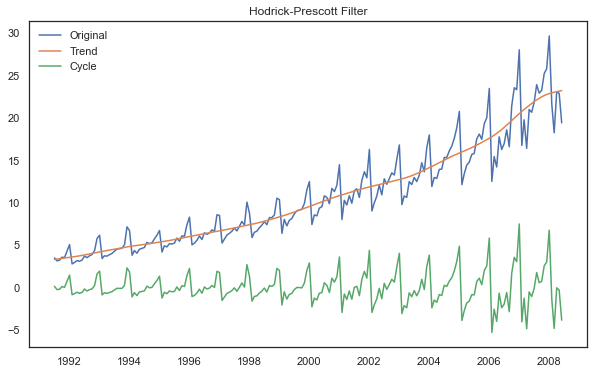

In [291]:
exp.apply_hodrick_prescott_filter()

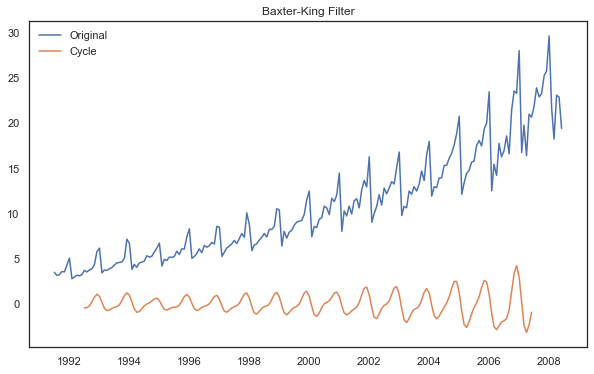

In [391]:
exp.apply_baxter_king_filter()

In [393]:
exp.calculate_granger_causality(df['value'])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=201, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=1264.3549, p=0.0000  , df_denom=201, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=199, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=716.2668, p=0.0000  , df_denom=199, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=197, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=478.3362, p=0.0000  , df_denom=197, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1.0000 

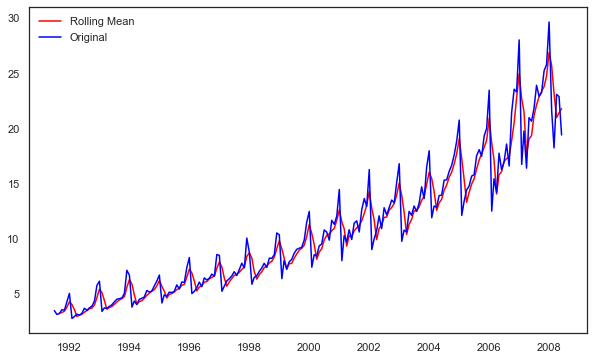

In [394]:
exp.plot_moving_average(3)

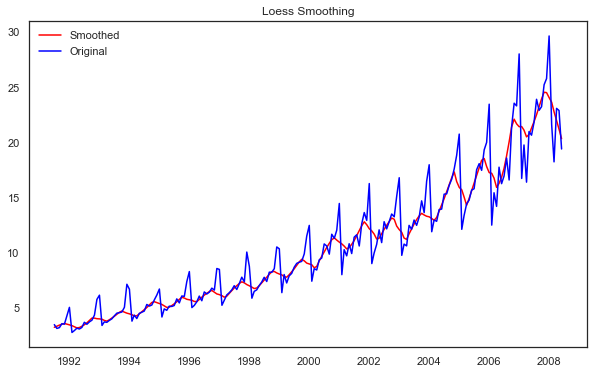

In [396]:
exp.plot_loess_smoothing('value',0.05)

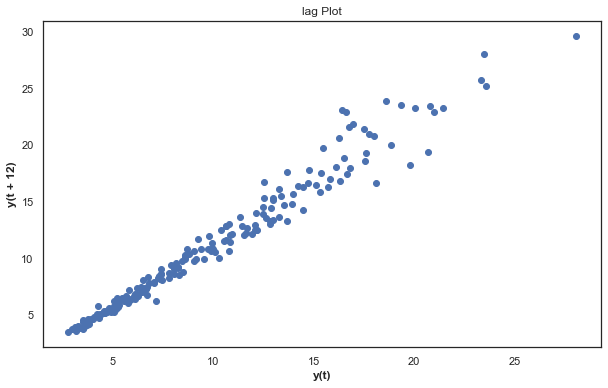

In [397]:
exp.plot_lag_plot(12)

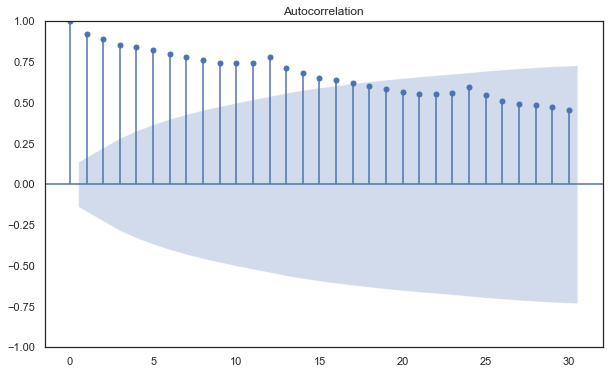

In [307]:
exp.plot_autocorrelation()

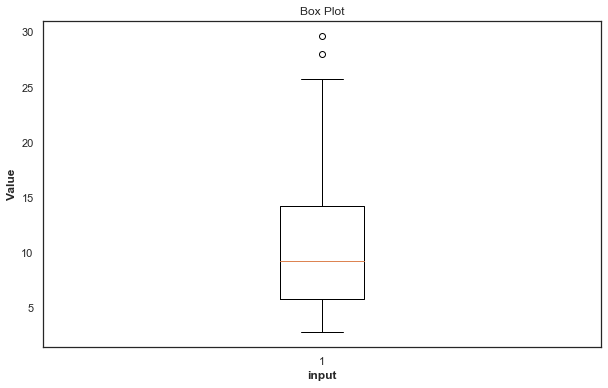

In [308]:
exp.plot_boxplot()

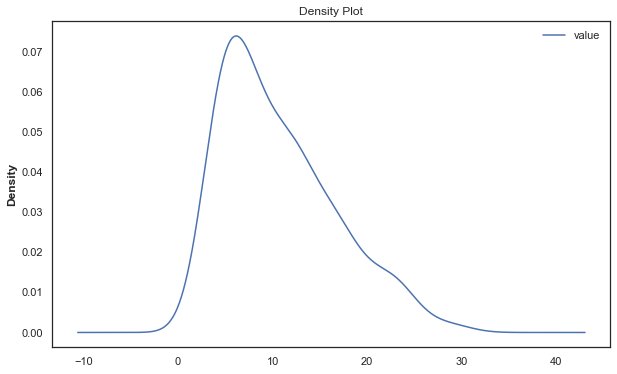

In [309]:
exp.plot_density()

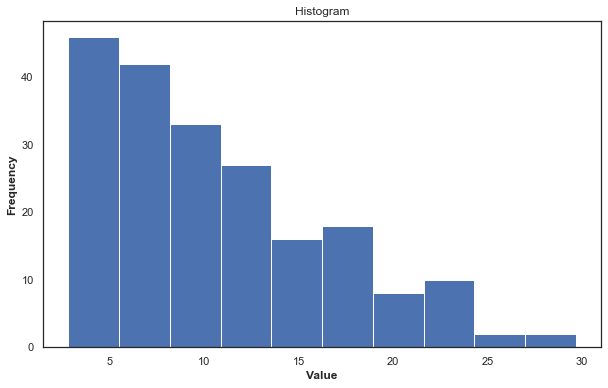

In [310]:
exp.plot_histogram()

In [311]:
exp.calculate_kpss_test()

KPSS test results:
KPSS test statistic: 2.0131256386303322
p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [312]:
exp.calculate_percentage_change()

value
date                
1991-08-01 -0.098027
1991-09-01  0.022425
1991-10-01  0.110319
1991-11-01 -0.012499
1991-12-01  0.207664
...              ...
2008-02-01 -0.270048
2008-03-01 -0.156521
2008-04-01  0.265138
2008-05-01 -0.008446
2008-06-01 -0.151916

[203 rows x 1 columns]

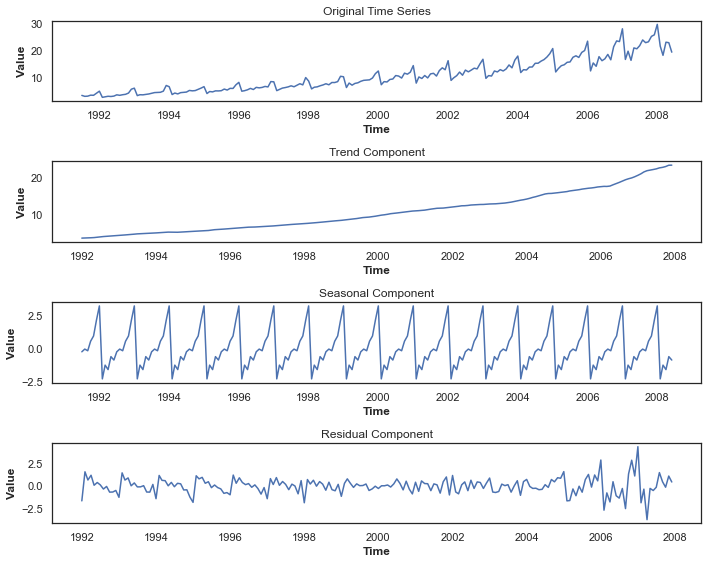

In [313]:
exp.plot_seasonal_decomposition(model='additive')

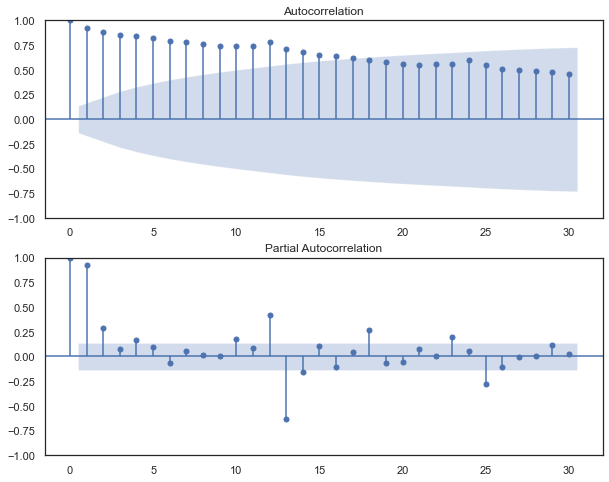

In [314]:
exp.plot_acf_pacf()

In [315]:
exp.calculate_seasonal_difference(12)

value
date                
1992-07-01  0.211260
1992-08-01  0.377885
1992-09-01  0.524981
1992-10-01  0.313487
1992-11-01  0.820662
...              ...
2008-02-01  4.890416
2008-03-01 -1.527809
2008-04-01  6.680372
2008-05-01  1.911768
2008-06-01 -1.249262

[192 rows x 1 columns]

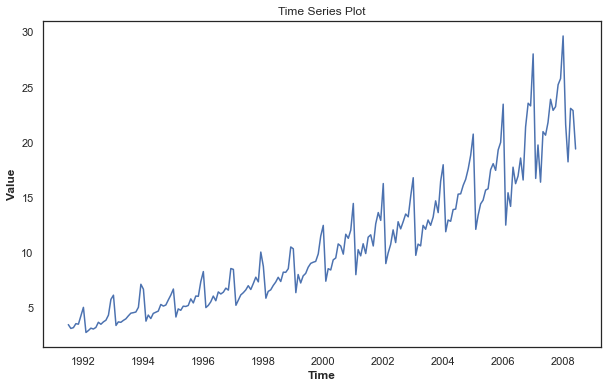

In [316]:
exp.plot_time_series()

In [317]:
x = pd.DataFrame(exp.log_transform())
type(x)
exp1 = EDA(x)

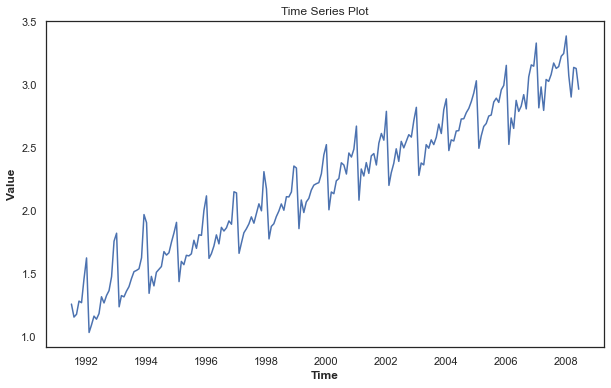

In [318]:
exp1.plot_time_series()

In [399]:
val1,lambd = exp.apply_boxcox_transformation('value')

In [400]:
lambd

0.061505584870954325

In [321]:
exp.calculate_hurst_exponent()

0.5695063064694355

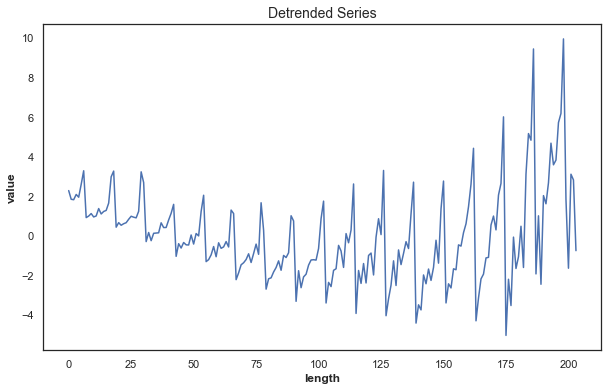

In [402]:
x1 = exp.apply_detrending('value')

In [323]:
exp.calculate_ndiffs()

('Estimated number of diffs :', 1)

In [351]:
exp.standardize_data()

array([[-1.20622366],
       [-1.26439901],
       [-1.2523954 ],
       [-1.19201857],
       [-1.19961385],
       [-1.07500013],
       [-0.94340907],
       [-1.32605293],
       [-1.29722761],
       [-1.2603789 ],
       [-1.27337066],
       [-1.24931548],
       [-1.17067227],
       [-1.20080746],
       [-1.16405019],
       [-1.13926404],
       [-1.06151059],
       [-0.82187287],
       [-0.75766988],
       [-1.21896838],
       [-1.16487391],
       [-1.17126932],
       [-1.14247681],
       [-1.11819559],
       [-1.07345285],
       [-1.03195112],
       [-1.02412976],
       [-1.01416922],
       [-0.94248242],
       [-0.59142427],
       [-0.66689726],
       [-1.15326733],
       [-1.06024096],
       [-1.11387854],
       [-1.03557587],
       [-1.0179112 ],
       [-0.99990638],
       [-0.8992736 ],
       [-0.9238681 ],
       [-0.90751161],
       [-0.82806686],
       [-0.75556201],
       [-0.66386636],
       [-1.09019667],
       [-0.96679794],
       [-0

In [352]:
exp.normalize_data()

array([[0.02651951],
       [0.01364468],
       [0.01630121],
       [0.02966325],
       [0.02798233],
       [0.05556069],
       [0.08468321],
       [0.        ],
       [0.00637935],
       [0.01453437],
       [0.01165915],
       [0.01698282],
       [0.03438741],
       [0.02771817],
       [0.03585295],
       [0.04133839],
       [0.05854607],
       [0.11158048],
       [0.12578929],
       [0.02369896],
       [0.03567065],
       [0.03425528],
       [0.04062737],
       [0.04600107],
       [0.05590312],
       [0.0650879 ],
       [0.06681885],
       [0.06902322],
       [0.08488829],
       [0.16258124],
       [0.14587825],
       [0.03823932],
       [0.05882705],
       [0.04695648],
       [0.0642857 ],
       [0.06819509],
       [0.07217975],
       [0.09445086],
       [0.08900784],
       [0.0926277 ],
       [0.11020968],
       [0.12625579],
       [0.14654902],
       [0.05219753],
       [0.079507  ],
       [0.07480307],
       [0.08864656],
       [0.087

In [373]:
exp.print_summary()

Data Summary:
               value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869


Number of observations: 204
Data type: float64
Start date: 1991-07-01 00:00:00
End date: 2008-06-01 00:00:00
Missing values: 0


In [381]:
exp.rolling_mean(2)

value
date                 
1991-07-01   3.526591
1991-08-01   3.353741
1991-09-01   3.216556
1991-10-01   3.431612
1991-11-01   3.588436
...               ...
2008-02-01  25.659821
2008-03-01  19.959615
2008-04-01  20.686311
2008-05-01  23.010094
2008-06-01  21.172125

[204 rows x 1 columns]

In [385]:
exp.normality_test()

Normality Test Result: statistic=[20.07577659], pvalue=[4.37119824e-05]
